In [91]:
# Quick analyses of noise, created for our shielding experiment at GHL but used for NIMR trials too

import numpy as np
import pandas as pd
from datetime import datetime, timezone, timedelta
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from ppg2rr import msptd_beat_detector, heart_rate

from scipy.signal import (
    bessel,
    sosfiltfilt,  
    welch,
)

In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
# Inputs

trial = "N07-034"
subtrial = "1"
probe = "Tr"
# df = pd.read_csv(f"/Users/wallace/Library/CloudStorage/Egnyte-nhgh/Shared/Projects/Pediatric Pulse ROxi/Shared with Diatomic/Noise investigation/{trial}/{subtrial}/per_sensor/{probe}Probe.csv")
# df = pd.read_csv(f"/Users/wallace/Library/CloudStorage/Egnyte-nhgh/Shared/Projects/Pediatric Pulse ROxi/Shared with Diatomic/Data/Raw/{trial}/{subtrial}/per_sensor/{probe}Probe.csv")
df = pd.read_csv(f"/Users/wallace/Projects/Pulse_ROxi/git/pulseox_pubalgs/data/3ps/primary/{trial}/{subtrial}/per_sensor/{probe}Probe.csv")

utc_offset = 1     # Seattle: -8 PST, -7 PDT. Nigeria: +1
line_opacity = 0.6

# Use only this subset of time, in seconds
t_start  = 45
t_length = 30

In [94]:
# Establish time bases

t_zero = df.at[0, "system_time"]
duration = df["system_time"].iloc[-1] - t_zero
fs_ppg = (len(df["system_time"]) - 1) / duration
if abs(fs_ppg - 500) >= 1:
    print(f"load_ppg_data(): For NIMR, fs_ppg is expected to be 500 Hz but was determined to be {fs_ppg:0.2f} Hz, a discrepancy over the {duration:0.1f} s trial of {duration * (500-fs_ppg)/500:0.2f} s.")
fs_ppg = round(fs_ppg)

df["system_time_dt"] = [datetime.fromtimestamp(sys_time, tz=timezone.utc).astimezone(timezone(timedelta(hours=utc_offset))) for sys_time in df["system_time"]]
df["linear_time"] = np.arange(0, len(df["system_time"])/fs_ppg, 1/fs_ppg)

In [95]:
# Invert by convention

df["LED1VAL"] *= -1
df["LED2VAL"] *= -1
df["LED1_DELTA"] *= -1
df["LED2_DELTA"] *= -1
df["ALED1VAL"] *= -1
df["ALED2VAL"] *= -1

In [96]:
# Low-pass filter all signals
order = 80
sos = bessel(order, 20, "lowpass", output="sos", fs=fs_ppg)
df["LED1VAL lpf 20 Hz"]  = sosfiltfilt(sos, df["LED1VAL"])
df["ALED1VAL lpf 20 Hz"] = sosfiltfilt(sos, df["ALED1VAL"])
df["LED2VAL lpf 20 Hz"]  = sosfiltfilt(sos, df["LED2VAL"])
df["ALED2VAL lpf 20 Hz"] = sosfiltfilt(sos, df["ALED2VAL"])

lpfs = [50, 40, 30, 20]
for f in lpfs:
    sos = bessel(order, f, "lowpass", output="sos", fs=fs_ppg)
    df[f"LED1_DELTA lpf {f} Hz"] = sosfiltfilt(sos, df["LED1_DELTA"])
    df[f"LED2_DELTA lpf {f} Hz"] = sosfiltfilt(sos, df["LED2_DELTA"])

In [97]:
hr_y, hr_x = heart_rate.estimate_instantaneous_heart_rate_with_resample(
            df["LED1_DELTA"], 
            fs_ppg, 
            hr_min = 60
        )
pass

In [98]:
t_length = min(t_length, df["linear_time"].iloc[-1])

filename_start = f"/Users/wallace/Projects/Pulse_ROxi/git/pulseox_pubalgs/data/results/nimr_{trial}_{probe}"
filename_subset = f"t{t_start}-{t_start + t_length:.0f}"

figtitle_start = f"{trial}/{subtrial} {probe}" 
figtitle_subset = f"{t_start}–{t_start + t_length:.0f} s"

In [99]:
df_subset = df[
    (df["linear_time"] >= t_start) &
    (df["linear_time"] < (t_start + t_length))
]
print(f"Subset start: {df_subset['system_time_dt'].iloc[0]}")
print(f"Subset end:   {df_subset['system_time_dt'].iloc[-1]}")
print(f"Duration:     {t_length:.0f} s")

Subset start: 2025-04-30 09:44:40.554000+01:00
Subset end:   2025-04-30 09:45:10.549000+01:00
Duration:     30 s


In [100]:
# Standard deviations within time subset

ALED1VAL_stddev = np.std(df_subset["ALED1VAL"])
ALED2VAL_stddev = np.std(df_subset["ALED2VAL"])
# print(f"Standard deviations within time subset:")
print(f"ALED1VAL: {ALED1VAL_stddev:.1f}")
print(f"ALED2VAL: {ALED2VAL_stddev:.1f}")
print(f"Average:  {np.mean([ALED1VAL_stddev, ALED2VAL_stddev]):.1f} ")

ALED1VAL: 46.4
ALED2VAL: 44.6
Average:  45.5 


In [110]:
# Novel peak detector

peaks1, onsets1 = msptd_beat_detector.msptd_beat_detector(df_subset[f"LED1_DELTA"], 500)

peaks1x = np.array(df_subset["linear_time"])[peaks1]
# peaks1y = np.array(df_subset["LED1_DELTA lpf 40 Hz"])[peaks1]
peaks1y = np.array(df_subset["LED1_DELTA"])[peaks1]

onsets1x = np.array(df_subset["linear_time"])[onsets1]
# onsets1y = np.array(df_subset["LED1_DELTA lpf 40 Hz"])[onsets1]
onsets1y = np.array(df_subset["LED1_DELTA"])[onsets1]

In [111]:
# All signals over time
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.03)

row = 1
fig.add_trace(go.Scatter(x=df_subset["linear_time"] + 0.75/fs_ppg, y=df_subset["ALED1VAL"], name="ALED1VAL", legendgroup=row, legendgrouptitle_text="LED off", mode="lines", line={"width":0.7, "color":"salmon"}, marker={"size":3}), row=row, col=1)
fig.add_trace(go.Scatter(x=df_subset["linear_time"] + 0.25/fs_ppg, y=df_subset["ALED2VAL"], name="ALED2VAL", legendgroup=row, legendgrouptitle_text="LED off", mode="lines", line={"width":0.7, "color":"dodgerblue"}, marker={"size":3}), row=row, col=1)
fig.update_xaxes(row=row, col=1, showticklabels=True)

row += 1
fig.add_trace(go.Scatter(x=df_subset["linear_time"] + 0.5/fs_ppg, y=df_subset["LED1VAL"], name="LED1VAL", legendgroup=row, legendgrouptitle_text="LED on", mode="lines", line={"width":0.7, "color":"red"}, marker={"size":3}), row=row, col=1)
fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["LED2VAL"], name="LED2VAL", legendgroup=row, legendgrouptitle_text="LED on", mode="lines", line={"width":0.7, "color":"blue"}, marker={"size":3}), row=row, col=1)
fig.update_xaxes(row=row, col=1, showticklabels=True)

row += 1
fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["LED1_DELTA"], name="LED1_DELTA", legendgroup=row, legendgrouptitle_text="Delta", mode="lines", line={"width":0.7, "color":"maroon"}, marker={"size":3}), row=row, col=1)
# fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["LED2_DELTA"], name="LED2_DELTA", legendgroup=row, legendgrouptitle_text="Delta", mode="lines", line={"width":0.7, "color":"darkblue"}, marker={"size":3}), row=row, col=1)
fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset[f"LED1_DELTA lpf 40 Hz"], name=f"LED1_DELTA lpf 40 Hz", legendgroup=row, legendgrouptitle_text="Delta", mode="lines", line={"width":1.25, "color":"darkblue"}, marker={"size":3}), row=row, col=1)
# fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset[f"LED2_DELTA lpf 40 Hz"], name=f"LED2_DELTA lpf 40 Hz", legendgroup=row, legendgrouptitle_text="Delta", mode="lines", line={"width":1.25, "color":"maroon"}, marker={"size":3}), row=row, col=1)
fig.add_trace(go.Scatter(x=peaks1x, y=peaks1y,   name="LED1_DELTA peaks",  legendgroup=row, legendgrouptitle_text="Delta", mode="markers", marker_size=7, marker_symbol="triangle-up-open", marker_color="blue"), row=row, col=1)
fig.add_trace(go.Scatter(x=onsets1x, y=onsets1y, name="LED1_DELTA onsets", legendgroup=row, legendgrouptitle_text="Delta", mode="markers", marker_size=7, marker_symbol="triangle-down-open", marker_color="green"), row=row, col=1)

row += 1
fig.add_trace(go.Scatter(x=hr_x, y=hr_y, name="LED1 HR", legendgroup=row, legendgrouptitle_text="HR", mode="lines", line={"width":0.7, "color":"maroon"}, marker={"size":3}), row=row, col=1)

fig.update_layout(title=f"{figtitle_start}",yaxis1_title="LED off", yaxis2_title="LED on", yaxis3_title="LED delta", xaxis4_title="elapsed time (s)", legend_groupclick = 'toggleitem', height=900)
# fig.update_layout(width=900)
fig.update_xaxes(range=[min(df_subset["linear_time"]), max(df_subset["linear_time"])])    # Otherwise, Plotly pads both ends because the plot uses markers
fig.update_traces(opacity=line_opacity)
fig.show()
# fig.write_html(f"{filename_start}_PPG_{filename_subset}.html", include_plotlyjs="directory")

In [112]:
# LED1 over time with the filters

if False:
    fig = make_subplots(rows=2, cols=1, row_heights=[1, 0.4], shared_xaxes=True, vertical_spacing=0.03)

    row = 1
    fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["LED1VAL"], name="LED1VAL", legendgroup=row, legendgrouptitle_text="LED on", mode="lines", line={"width":0.8}, marker={"size":3}), row=row, col=1)
    fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["LED1VAL lpf 20 Hz"], name="LED1VAL lpf 20 Hz", legendgroup=row, legendgrouptitle_text="LED on", mode="lines", line={"width":1}, marker={"size":3}), row=row, col=1)

    fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["LED1_DELTA"], name="LED1_DELTA", legendgroup=row, legendgrouptitle_text="Delta", mode="lines", line={"width":0.8}, marker={"size":3}), row=row, col=1)
    for f in lpfs:
        fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset[f"LED1_DELTA lpf {f} Hz"], name=f"LED1_DELTA lpf {f} Hz", legendgroup=row, legendgrouptitle_text="Delta", mode="lines", line={"width":1.25}, marker={"size":3}), row=row, col=1)

    row += 1
    fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["ALED1VAL"], name="ALED1VAL", legendgroup=row, legendgrouptitle_text="LED off", mode="lines", line={"width":0.8}, marker={"size":3}), row=row, col=1)
    fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["ALED1VAL lpf 20 Hz"], name="ALED1VAL lpf 20 Hz", legendgroup=row, legendgrouptitle_text="LED off", mode="lines", line={"width":1}, marker={"size":3}), row=row, col=1)

    fig.update_layout(title=f"{figtitle_start}",yaxis1_title="LED on", yaxis2_title="LED off", xaxis2_title="elapsed time (s)", legend_groupclick = 'toggleitem', width=1400, height=900)
    fig.update_xaxes(range=[min(df_subset["linear_time"]), max(df_subset["linear_time"])])    # Otherwise, Plotly pads both ends because the plot uses markers
    fig.update_traces(opacity=line_opacity)
    fig.show()
    # fig.write_html(f"/Users/wallace/Projects/Pulse_ROxi/git/pulseox_pubalgs/data/results/{trial_filename_title}_PPG.html", include_plotlyjs="directory")

In [113]:
# Same as above but for LED2

if False:
    fig = make_subplots(rows=2, cols=1, row_heights=[1, 0.4], shared_xaxes=True, vertical_spacing=0.03)

    row = 1
    fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["LED2VAL"], name="LED2VAL", legendgroup=row, legendgrouptitle_text="LED on", mode="lines", line={"width":0.8}, marker={"size":3}), row=row, col=1)
    fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["LED2VAL lpf 20 Hz"], name="LED2VAL lpf 20 Hz", legendgroup=row, legendgrouptitle_text="LED on", mode="lines", line={"width":1}, marker={"size":3}), row=row, col=1)

    fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["LED2_DELTA"], name="LED2_DELTA", legendgroup=row, legendgrouptitle_text="Delta", mode="lines", line={"width":0.8}, marker={"size":3}), row=row, col=1)
    for f in lpfs:
        fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset[f"LED2_DELTA lpf {f} Hz"], name=f"LED2_DELTA lpf {f} Hz", legendgroup=row, legendgrouptitle_text="Delta", mode="lines", line={"width":1.25}, marker={"size":3}), row=row, col=1)

    row += 1
    fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["ALED2VAL"], name="ALED2VAL", legendgroup=row, legendgrouptitle_text="LED off", mode="lines", line={"width":0.8}, marker={"size":3}), row=row, col=1)
    fig.add_trace(go.Scatter(x=df_subset["linear_time"], y=df_subset["ALED2VAL lpf 20 Hz"], name="ALED2VAL lpf 20 Hz", legendgroup=row, legendgrouptitle_text="LED off", mode="lines", line={"width":1}, marker={"size":3}), row=row, col=1)

    fig.update_layout(title=f"{figtitle_start}",yaxis1_title="LED on", yaxis2_title="LED off", xaxis2_title="elapsed time (s)", legend_groupclick = 'toggleitem', width=1400, height=900)
    fig.update_xaxes(range=[min(df_subset["linear_time"]), max(df_subset["linear_time"])])    # Otherwise, Plotly pads both ends because the plot uses markers
    fig.update_traces(opacity=line_opacity)
    fig.show()
    # fig.write_html(f"/Users/wallace/Projects/Pulse_ROxi/git/pulseox_pubalgs/data/results/{trial_filename_title}_PPG.html", include_plotlyjs="directory")

In [114]:
# PSDs

fft_scalar = 2
nperseg=min([1024 * fft_scalar, len(df_subset)])
nfft=max(8192 * fft_scalar, nperseg)

f_1, Pxx_1 = welch(df_subset["LED1VAL"], fs=fs_ppg, nperseg=nperseg, nfft=nfft)
f_2, Pxx_2 = welch(df_subset["LED2VAL"], fs=fs_ppg, nperseg=nperseg, nfft=nfft)
f_a1, Pxx_a1 = welch(df_subset["ALED1VAL"], fs=fs_ppg, nperseg=nperseg, nfft=nfft)
f_a2, Pxx_a2 = welch(df_subset["ALED2VAL"], fs=fs_ppg, nperseg=nperseg, nfft=nfft)
f_d1, Pxx_d1 = welch(df_subset["LED1_DELTA"], fs=fs_ppg, nperseg=nperseg, nfft=nfft)
f_d2, Pxx_d2 = welch(df_subset["LED2_DELTA"], fs=fs_ppg, nperseg=nperseg, nfft=nfft)

width = 0.8
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=f_1, y=Pxx_1, mode="lines", name="LED1VAL", line={"width":width, "color":"red"}))
fig2.add_trace(go.Scatter(x=f_2, y=Pxx_2, mode="lines", name="LED2VAL", line={"width":width, "color":"blue"}))
fig2.add_trace(go.Scatter(x=f_a1, y=Pxx_a1, mode="lines", name="ALED1VAL", line={"width":width, "color":"salmon"}))
fig2.add_trace(go.Scatter(x=f_a2, y=Pxx_a2, mode="lines", name="ALED2VAL", line={"width":width, "color":"dodgerblue"}))
fig2.add_trace(go.Scatter(x=f_d1, y=Pxx_d1, mode="lines", name="LED1_DELTA", line={"width":width, "color":"maroon"}))
fig2.add_trace(go.Scatter(x=f_d2, y=Pxx_d2, mode="lines", name="LED2_DELTA", line={"width":width, "color":"darkblue"}))
fig2.update_layout(title=f"{figtitle_start} {figtitle_subset}", xaxis_title="frequency (Hz)", yaxis_title="Power", yaxis_type="log", width=800, height=500)
fig2.update_xaxes(dtick=50)
fig2.update_yaxes(range=[0,8])      # in logs
# fig2.update_xaxes(range=[0,250])
fig2.update_traces(opacity=line_opacity)
fig2.show()
# fig2.write_html(f"{filename_start}_PSD_{filename_subset}.html", include_plotlyjs="directory")

Text(0, 0.5, 'Frequency [Hz]')

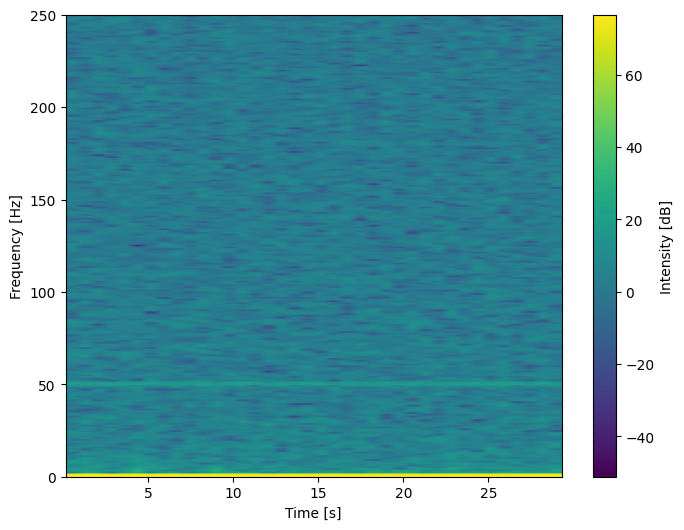

In [115]:
# Spectrogram ALED1VAL

fig, ax = plt.subplots(figsize=(8,6))
Pxx, freqa, bins, im = ax.specgram(df_subset["ALED1VAL"], NFFT=512, Fs=fs_ppg, scale='dB')
fig.colorbar(im).set_label('Intensity [dB]')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Frequency [Hz]")

Text(0, 0.5, 'Frequency [Hz]')

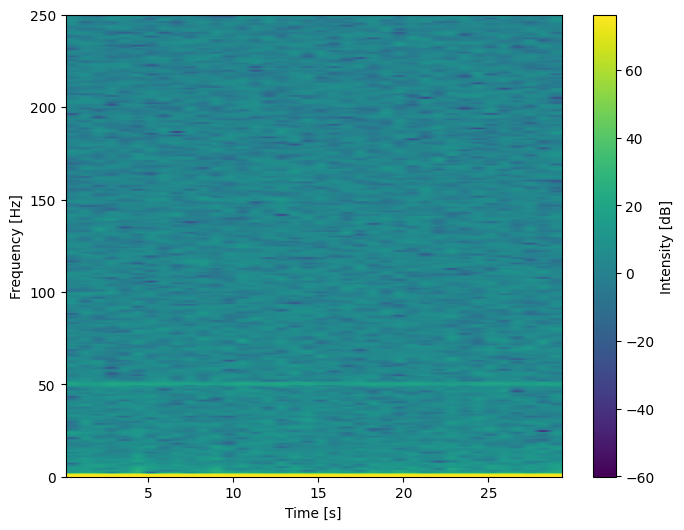

In [116]:
# Spectrogram ALED2VAL

fig, ax = plt.subplots(figsize=(8,6))
Pxx, freqa, bins, im = ax.specgram(df_subset["ALED2VAL"], NFFT=512, Fs=fs_ppg, scale='dB')
fig.colorbar(im).set_label('Intensity [dB]')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Frequency [Hz]")